In [1]:
from Bio.PDB import *
from Bio.PDB.PDBExceptions import PDBConstructionWarning
import freesasa
import numpy as np
import matplotlib.pyplot as plt
import math

from pdb_io import *
from geometry import get_rotation
from q_value import calc_Q_value

import sys
import argparse
import warnings

In [2]:
model = parse_PDB('./structures/pdb1u9j.pdb')
model = position_model(model)

slice_scores1, z_min1, z_max1 = calc_Q_value(model, [-1,1,0])
slice_scores2, z_min2, z_max2 = calc_Q_value(model, [1,-1,0])

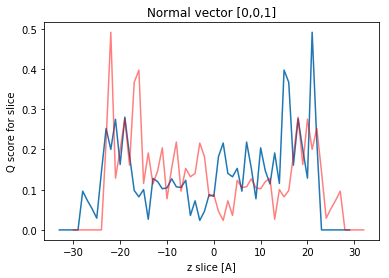

In [4]:
plt.figure()
plt.plot(range(z_min1,z_max1), slice_scores1)
plt.plot(range(z_min2,z_max2), slice_scores2, color='red', alpha=0.5)
plt.title('Normal vector [0,0,1]')
plt.xlabel('z slice [A]')
plt.ylabel('Q score for slice');

In [43]:
np.argmax([1,5,7,3,1,5223,2])

5

In [7]:
def get_max_sliding_window(scores, window=15):
    avgs = [sum(scores[i:(i+window)])/window for i in range(len(scores)-window)]

    max_score = max(avgs)
    max_index = np.argmax(avgs)
    
    return max_score, max_index, avgs
    
max_score, max_index, avgs = get_max_sliding_window(slice_scores1, 20)
print(max_score, max_index)

0.19916536570087542 36


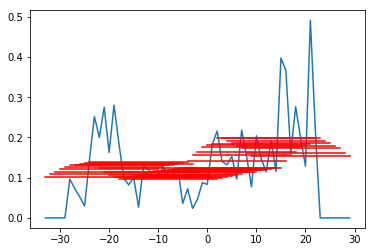

In [8]:
# for plotting avgs from get_max_sliding_window
plt.figure()
plt.plot(range(z_min1,z_max1), slice_scores1)
for i, avg in enumerate(avgs):
    plt.plot([z_min1+i, z_min1+i+20], [avg, avg], color="red")

In [10]:
"""
model = parse_PDB('./structures/pdb1u9j.pdb')
model = position_model(model)

z_min, z_max = get_z_bounds(model)
print(z_min, z_max)
    

slices = make_slices(model, z_min, z_max)
"""

-25 25


[-30, 30, -30, 30]

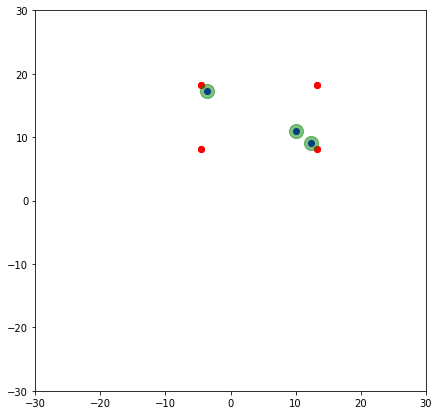

In [155]:
test_slice = -25

xs = []
ys = []
for atom in slices[test_slice]:
    xs.append(atom.coord[0])
    ys.append(atom.coord[1])
    

xs_rect = []
ys_rect = []
points = rectangle_grid(slices[test_slice], test_slice + 0.5)

for point in points:
    xs_rect.append(point[0])
    ys_rect.append(point[1])
    
    
xs_out = []
ys_out = []
outer_atoms, outer_atom_ids = get_outer_atoms(slices[test_slice], points)

for atom in list(outer_atoms):
    xs_out.append(atom.coord[0])
    ys_out.append(atom.coord[1])
    
    
plt.figure(figsize=(7,7))
plt.scatter(xs,ys, color="blue")
plt.scatter(xs_rect, ys_rect, color="red")
plt.scatter(xs_out, ys_out, color="green", s = 200, alpha=0.5)
plt.axis([-30,30,-30,30])

In [2]:
def calc_structure_factor(slice_list, residue_dict, vector):
    residue_ids = get_unique_residues_from_slice(slice_list)
    if len(residue_ids) == 0:
        return 0.00001
    straight_count = 0
    turn_count = 0
    endchain_count = 0
    
    
    for chain, resi in residue_ids:
        # Residue i-3
        try:
            prev_res = residue_dict[chain][resi-3].coord
        except KeyError:
            endchain_count += 1
            continue

        # Residue i
        curr_res = residue_dict[chain][resi].coord

        # Residue i+3
        try:
            next_res = residue_dict[chain][resi+3].coord
        except KeyError:
            endchain_count += 1
            continue

        prev_value = np.dot(vector, prev_res)
        curr_value = np.dot(vector, curr_res)
        next_value = np.dot(vector, next_res)

        if (prev_value < curr_value and curr_value < next_value) or (prev_value > curr_value and curr_value > next_value):
            straight_count += 1
        else:
            turn_count += 1
    
    straightness_factor = straight_count / len(residue_ids)
    turn_factor = 1 - (turn_count / len(residue_ids))
    endchain_factor = 1 - (endchain_count / len(residue_ids))    
    
    return straightness_factor * turn_factor * endchain_factor

In [139]:
straight_count = 0
turn_count = 0
endchain_count = 0

vector = np.array([0,0,1])

for chain, resi in residue_ids:
    try:
        prev_res = residue_dict[chain][resi-3].coord
    except KeyError:
        endchain_count += 1
        
    curr_res = residue_dict[chain][resi].coord
    
    try:
        next_res = residue_dict[chain][resi+3].coord
    except KeyError:
        endchain_count += 1
        
    prev_value = np.dot(vector, prev_res)
    curr_value = np.dot(vector, curr_res)
    next_value = np.dot(vector, next_res)
    
    if (prev_value < curr_value and curr_value < next_value) or (prev_value > curr_value and curr_value > next_value):
        straight_count += 1
    else:
        turn_count += 1

straightness_factor = straight_count / len(residue_ids)
turn_factor = 1 - (turn_count / len(residue_ids))
endchain_factor = 1 - (endchain_count / len(residue_ids))

structure_factor = straightness_factor * turn_factor * endchain_factor
print(structure_factor)

0.5216049382716049
